# Video Game Sales dataset

Source: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings

### Guiding Questions:
- As a game developer, what type of game should I make next?
- What platform should I release my game on?
- What genre?
- What regions should I target?
- Should I partner with a certain publisher?

# Import and Clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('ggplot')

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
path = 'Video_Games_Sales_as_at_22_Dec_2016.csv'

games = pd.read_csv(path)

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#make column names lowercase
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'publisher', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'global_sales', 'critic_score',
       'critic_count', 'user_score', 'user_count', 'developer', 'rating'],
      dtype='object')

In [5]:
#check null values
games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
publisher            54
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
critic_score       8582
critic_count       8582
user_score         6704
user_count         9129
developer          6623
rating             6769
dtype: int64

In [6]:
games[games["name"].isnull()]

,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating
659,NaN,GEN,1993.0,NaN,Acclaim Entertainment,1.78,0.53,0.00,0.08,2.39,NaN,NaN,NaN,NaN,NaN,NaN
14246,NaN,GEN,1993.0,NaN,Acclaim Entertainment,0.00,0.00,0.03,0.00,0.03,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#drop null name rows
games.dropna(axis = 0, subset=["name"], inplace=True)

In [8]:
#replace null publisher values with Unknown
games["publisher"].fillna(value="Unknown",inplace=True)

In [9]:
#check null values
games.isnull().sum()

name                  0
platform              0
year_of_release     269
genre                 0
publisher             0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
critic_score       8580
critic_count       8580
user_score         6702
user_count         9127
developer          6621
rating             6767
dtype: int64

In [10]:
#replace null year_of_release values with the average year per platform
d = dict(games.groupby("platform")["year_of_release"].mean())
d

{'2600': 1982.1379310344828,
 '3DO': 1994.6666666666667,
 '3DS': 2013.126953125,
 'DC': 1999.9423076923076,
 'DS': 2008.1908576814326,
 'GB': 1995.9587628865979,
 'GBA': 2003.2108508014796,
 'GC': 2003.40036900369,
 'GEN': 1993.037037037037,
 'GG': 1992.0,
 'N64': 1998.5316455696202,
 'NES': 1987.1530612244899,
 'NG': 1994.5,
 'PC': 2008.9143155694881,
 'PCFX': 1996.0,
 'PS': 1998.0058823529412,
 'PS2': 2004.5839210155148,
 'PS3': 2010.8407350689126,
 'PS4': 2015.1501272264632,
 'PSP': 2008.7317686504609,
 'PSV': 2014.1461716937356,
 'SAT': 1996.028901734104,
 'SCD': 1993.8333333333333,
 'SNES': 1993.8451882845188,
 'TG16': 1995.0,
 'WS': 2000.0,
 'Wii': 2008.9665629860031,
 'WiiU': 2013.6598639455783,
 'X360': 2009.8806818181818,
 'XB': 2003.6363636363637,
 'XOne': 2014.9514170040486}

In [11]:
def imputer(i):
    if pd.isnull(i.year_of_release):
        return d[i.platform]
    else:
        return i.year_of_release

In [12]:
games["year_of_release"] = games.apply(imputer, axis = 1)

In [13]:
#check null values
games.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
publisher             0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
critic_score       8580
critic_count       8580
user_score         6702
user_count         9127
developer          6621
rating             6767
dtype: int64

In [14]:
#convert year_of_release from float to integer
games.year_of_release = games.year_of_release.astype("int64")

In [15]:
#make an array of strings from year_of_release
years = []

for g in games["year_of_release"]:
    string = str(g)
    years.append(string)

In [16]:
#create new column with unique name + platform + year
games["concatenated"] = games["name"] + " - " + games["platform"] + " - " + years

In [17]:
games["concatenated"].head()

0                 Wii Sports - Wii - 2006
1          Super Mario Bros. - NES - 1985
2             Mario Kart Wii - Wii - 2008
3          Wii Sports Resort - Wii - 2009
4    Pokemon Red/Pokemon Blue - GB - 1996
Name: concatenated, dtype: object

In [18]:
#find duplicate values in concatenated column
games[games.duplicated(subset="concatenated", keep=False)]

,name,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating,concatenated
604,Madden NFL 13,PS3,2012,Sports,Electronic Arts,2.11,0.22,0.0,0.23,2.56,83.0,22.0,5.5,101.0,EA Tiburon,E,Madden NFL 13 - PS3 - 2012
16233,Madden NFL 13,PS3,2012,Sports,Electronic Arts,0.00,0.01,0.0,0.00,0.01,83.0,22.0,5.5,101.0,EA Tiburon,E,Madden NFL 13 - PS3 - 2012


In [19]:
#drop the duplicate
games.drop([16233], axis = 0, inplace=True)

In [20]:
#set concatenated as the index and drop name column
games.set_index("concatenated", inplace=True)
games.drop('name', axis=1, inplace=True)

In [21]:
games.head()

,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating
concatenated,,,,,,,,,,,,,,,
Wii Sports - Wii - 2006,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
Super Mario Bros. - NES - 1985,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
Mario Kart Wii - Wii - 2008,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
Wii Sports Resort - Wii - 2009,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
Pokemon Red/Pokemon Blue - GB - 1996,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#replace 'tbd' values with nan in user_score column
games["user_score"].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [23]:
games["user_score"] = games["user_score"].replace('tbd', np.nan, regex=True)
games["user_score"].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', nan], dtype=object)

In [24]:
#convert user_score to float
games.user_score = games.user_score.astype("float64")

In [25]:
games.dtypes

platform            object
year_of_release      int64
genre               object
publisher           object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
global_sales       float64
critic_score       float64
critic_count       float64
user_score         float64
user_count         float64
developer           object
rating              object
dtype: object

In [26]:
#replace null values for devleoper and rating with Unknown
games["developer"].fillna(value="Unknown",inplace=True)
games["rating"].fillna(value="Unknown",inplace=True)

In [27]:
#check null values
games.isnull().sum()

platform              0
year_of_release       0
genre                 0
publisher             0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
global_sales          0
critic_score       8580
critic_count       8580
user_score         9127
user_count         9127
developer             0
rating                0
dtype: int64

In [28]:
#drop rows where year_of_release > 2016
games = games[games.year_of_release < 2017]

# Exploratory Data Analysis & Insights

### 1. What are the most popular genres?

Text(0.5,1,'Percentage of Games Released by Genre')

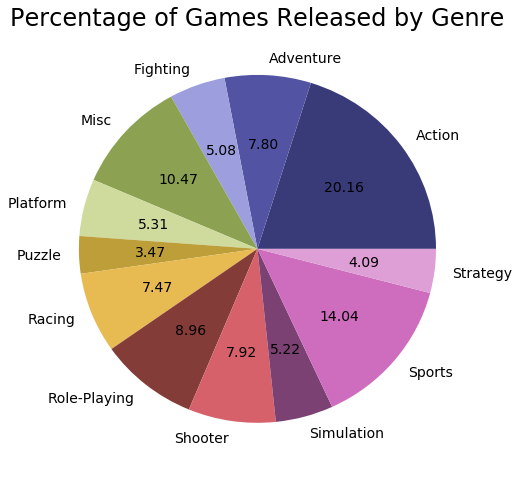

In [29]:
#genre popularity

genrepopularity = games["genre"].value_counts().sort_index()

genrepopularity.plot(kind="pie", figsize=(8,8), fontsize = 14, colormap="tab20b", autopct='%.2f')
#plt.xticks(rotation='horizontal')
plt.ylabel("")
plt.title("Percentage of Games Released by Genre", fontsize = 24)

### 2. How has genre popularity changed over time? What genre was popular in the 80s, 90s, 00s, 10s?

In [30]:
###plot total games releases by genre by decade

In [31]:
games80s = games[(games["year_of_release"] >= 1980) & (games["year_of_release"] < 1990)]
games90s = games[(games["year_of_release"] >= 1990) & (games["year_of_release"] < 2000)]
games00s = games[(games["year_of_release"] >= 2000) & (games["year_of_release"] < 2010)]
games10s = games[(games["year_of_release"] >= 2010) & (games["year_of_release"] < 2017)]

Text(0,0.5,'Number of Games')

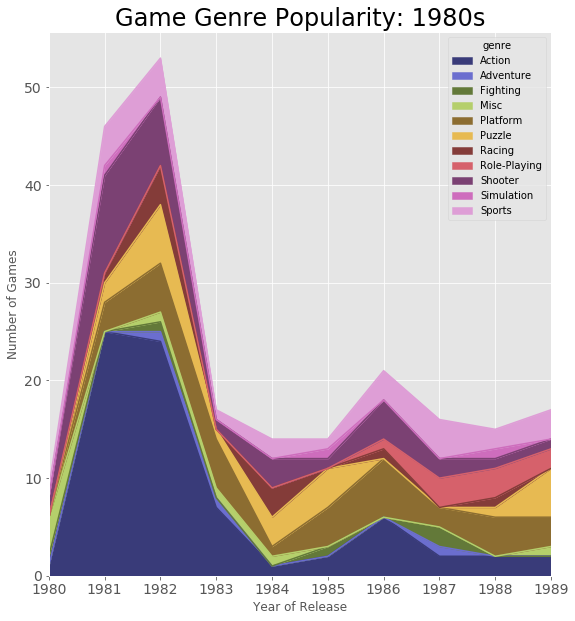

In [32]:
games80s.groupby("year_of_release")["genre"].value_counts().unstack().plot(kind = "area", 
                                                                           figsize = (9,10), 
                                                                           stacked=True,
                                                                           colormap="tab20b",
                                                                           fontsize=14)
plt.title("Game Genre Popularity: 1980s", fontsize = 24)
plt.xlabel("Year of Release")
plt.ylabel("Number of Games")

In [33]:
#get a count of the games released by genre
#games80s["genre"].value_counts()

Text(0,0.5,'Number of Games')

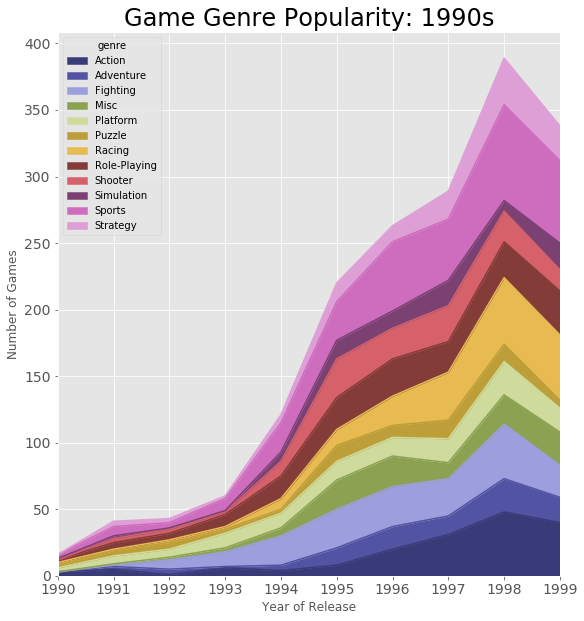

In [34]:
games90s.groupby("year_of_release")["genre"].value_counts().unstack().plot(kind = "area", 
                                                                           figsize = (9,10), 
                                                                           stacked=True,
                                                                           colormap="tab20b",
                                                                           fontsize=14)
plt.title("Game Genre Popularity: 1990s", fontsize = 24)
plt.xlabel("Year of Release")
plt.ylabel("Number of Games")

Text(0,0.5,'Number of Games')

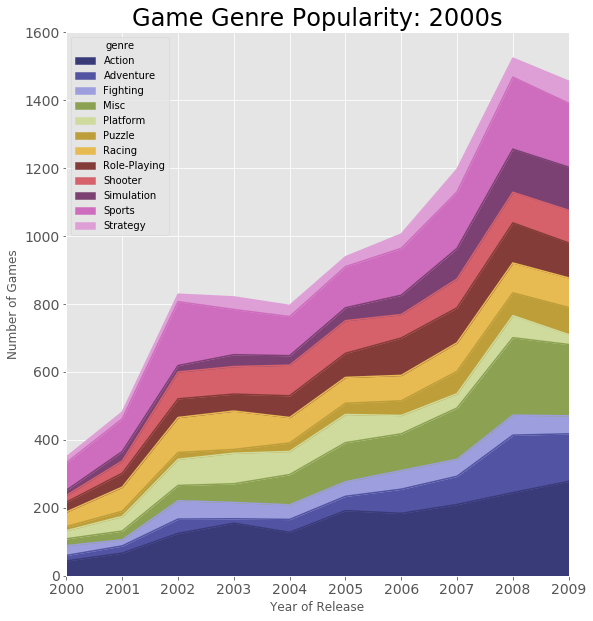

In [35]:
games00s.groupby("year_of_release")["genre"].value_counts().unstack().plot(kind = "area", 
                                                                           figsize = (9,10), 
                                                                           stacked=True,
                                                                           colormap="tab20b",
                                                                           fontsize=14)
plt.title("Game Genre Popularity: 2000s", fontsize = 24)
plt.xlabel("Year of Release")
plt.ylabel("Number of Games")

Text(0,0.5,'Number of Games')

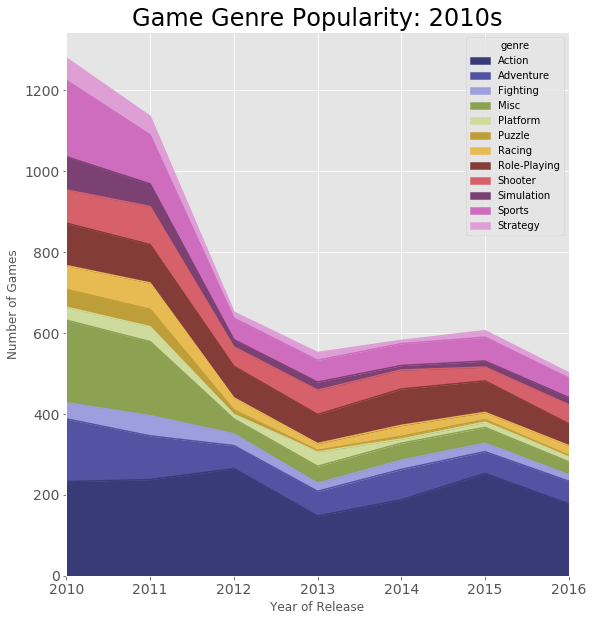

In [36]:
games10s.groupby("year_of_release")["genre"].value_counts().unstack().plot(kind = "area", 
                                                                           figsize = (9,10), 
                                                                           stacked=True,
                                                                           colormap="tab20b",
                                                                           fontsize=14)
plt.title("Game Genre Popularity: 2010s", fontsize = 24)
plt.xlabel("Year of Release")
plt.ylabel("Number of Games")

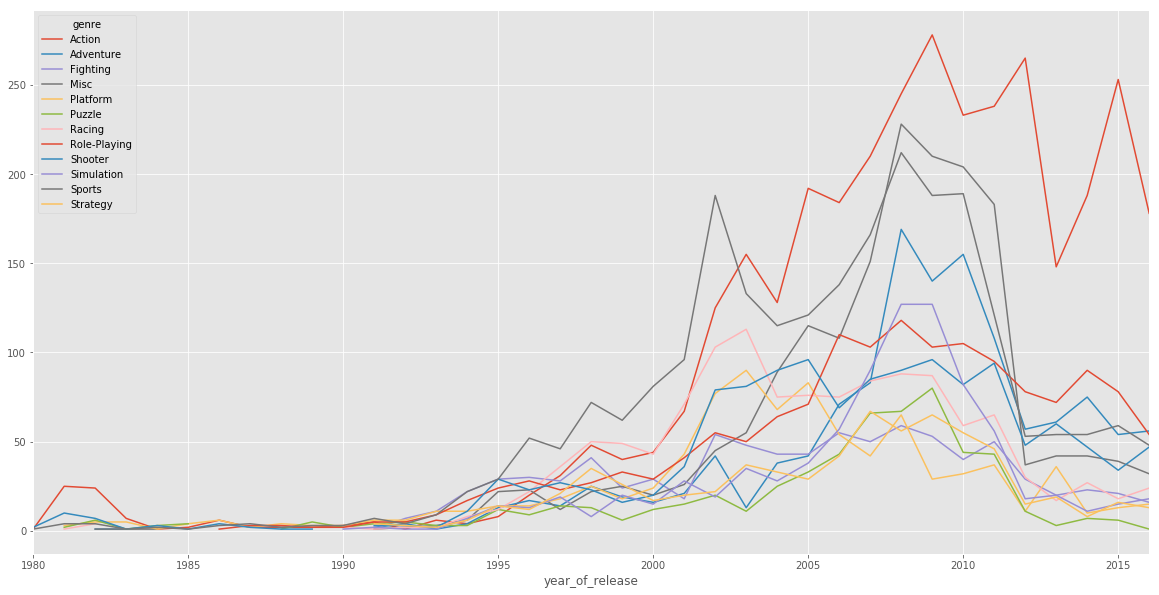

In [37]:
#plot total number of games by genre
games.groupby("year_of_release")["genre"].value_counts().unstack().plot(kind = "line", 
                                                                        figsize = (20,10),
                                                                        
                                                                       )

### 3. How many games are released each year? What are the global sales numbers?

Text(0.5,1,'Total Count of Games Released by Year')

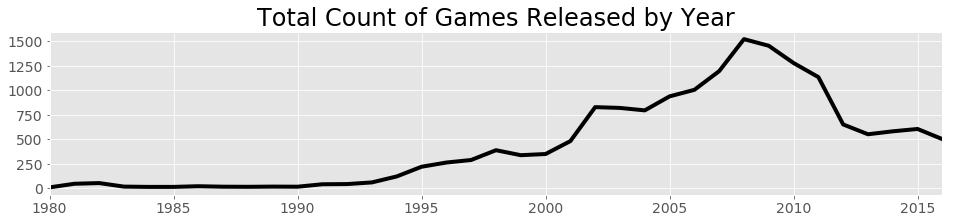

In [38]:
#number of games released each year

numgames = games["year_of_release"].value_counts().sort_index()

numgames.plot(figsize=(16,3), 
              fontsize = 14,
              linewidth=4,
              color = "black"
             )
plt.title("Total Count of Games Released by Year", fontsize = 24)

In [39]:
#global sales over time
world = games.groupby("year_of_release")["global_sales"].sum()

Text(0.5,0,'')

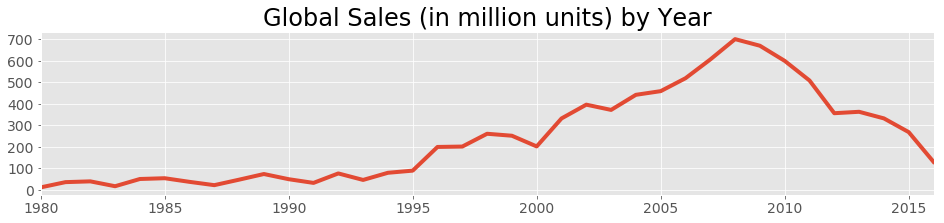

In [40]:
world.plot(figsize=(16,3), 
              fontsize = 14,
              linewidth=4,
             )
plt.title("Global Sales (in million units) by Year", fontsize = 24)
plt.xlabel("")

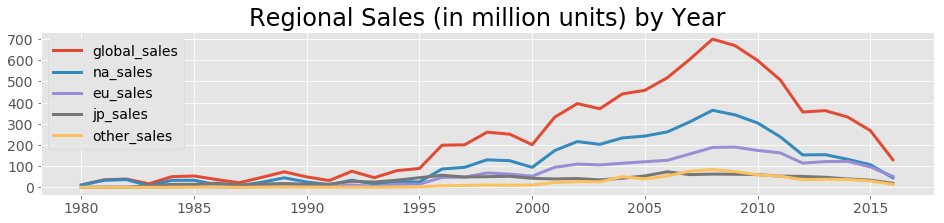

In [41]:
#plot global and regional sales on one plot

namerica = games.groupby("year_of_release")["na_sales"].sum()
eu = games.groupby("year_of_release")["eu_sales"].sum()
jp = games.groupby("year_of_release")["jp_sales"].sum()
other = games.groupby("year_of_release")["other_sales"].sum()

plt.figure(figsize=(16,3))
plt.title("Regional Sales (in million units) by Year", fontsize = 24)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot(world, linewidth = 3)
plt.plot(namerica, linewidth = 3)
plt.plot(eu, linewidth = 3)
plt.plot(jp, linewidth = 3)
plt.plot(other, linewidth = 3)
plt.legend(fontsize=14)

### 4. Why is there a decline in sales after 2008?
- Find out how the sales data was recorded and when it was last pulled
- If a game was released in Dec 2016, it may not have as high sales numbers as games from 2015 or 2014
- How has mobile gaming impacted sales/releases of platform games?
- Fewer unique gaming titles released per year offset by an increasing amount of in-game sales

### 5. What genre of games has the most global sales today? JP sales?

In [42]:
#max sales by genre - globally
games.groupby("genre")["global_sales"].max().sort_values(ascending=False)

genre
Sports          82.53
Platform        40.24
Racing          35.52
Role-Playing    31.37
Puzzle          30.26
Misc            28.92
Shooter         28.31
Simulation      24.67
Action          21.04
Fighting        12.84
Adventure       11.18
Strategy         5.45
Name: global_sales, dtype: float64

In [43]:
#mean sales by genre - globally
games.groupby("genre")["global_sales"].mean().sort_values(ascending=False)

genre
Platform        0.932523
Shooter         0.795873
Role-Playing    0.623732
Racing          0.583587
Sports          0.567529
Fighting        0.527067
Action          0.518035
Misc            0.458960
Simulation      0.446884
Puzzle          0.419000
Strategy        0.255490
Adventure       0.182417
Name: global_sales, dtype: float64

In [44]:
#total sales by platform
games.groupby("platform")["global_sales"].sum().sort_values(ascending=False)

platform
PS2     1255.64
X360     971.63
PS3      939.42
Wii      908.13
DS       806.81
PS       730.68
GBA      318.50
PS4      314.19
PSP      294.30
PC       260.30
3DS      259.09
XB       258.26
GB       255.45
NES      251.07
N64      218.88
SNES     200.05
GC       199.36
XOne     159.44
2600      97.08
WiiU      82.16
PSV       54.10
SAT       33.59
GEN       28.36
DC        15.97
SCD        1.87
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: global_sales, dtype: float64

In [45]:
#mean sales per game
games["global_sales"].mean()

0.5335998085209002

In [46]:
#games with max sales
games.global_sales.head()

concatenated
Wii Sports - Wii - 2006                 82.53
Super Mario Bros. - NES - 1985          40.24
Mario Kart Wii - Wii - 2008             35.52
Wii Sports Resort - Wii - 2009          32.77
Pokemon Red/Pokemon Blue - GB - 1996    31.37
Name: global_sales, dtype: float64

### 6. Which publishers have the max highest sales and mean highest sales in each region?

In [47]:
#publisher sales globally
games.groupby("publisher")["global_sales"].sum().sort_values(ascending=False).head()

publisher
Nintendo                       1788.81
Electronic Arts                1116.95
Activision                      731.16
Sony Computer Entertainment     606.48
Ubisoft                         471.32
Name: global_sales, dtype: float64

In [48]:
#games.groupby("developer")["global_sales"].sum().sort_values(ascending=False)

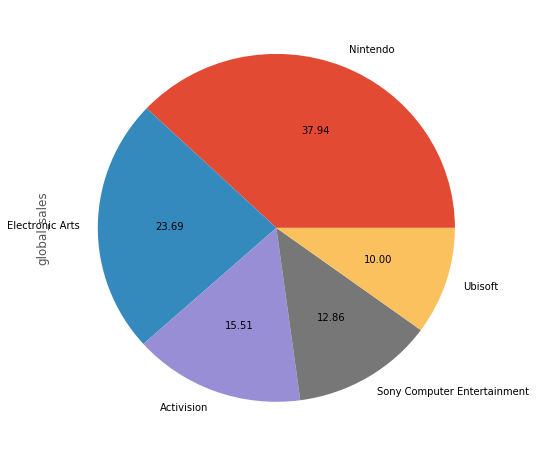

In [49]:
games.groupby("publisher")["global_sales"].sum().sort_values(ascending=False).head().plot(kind="pie", 
                                                                                     figsize = (8,8), 
                                                                                      autopct='%.2f' 
                                                                                     )

In [50]:
#games.groupby("publisher")["na_sales"].sum().sort_values(ascending=False).head().plot(kind="pie", 
#                                                                                      figsize = (8,8), 
#                                                                                      autopct='%.2f' 
#                                                                                     )

In [51]:
#games.groupby("publisher")["eu_sales"].sum().sort_values(ascending=False).head().plot(kind="pie", 
#                                                                                      figsize = (8,8), 
#                                                                                      autopct='%.2f' 
#                                                                                     )

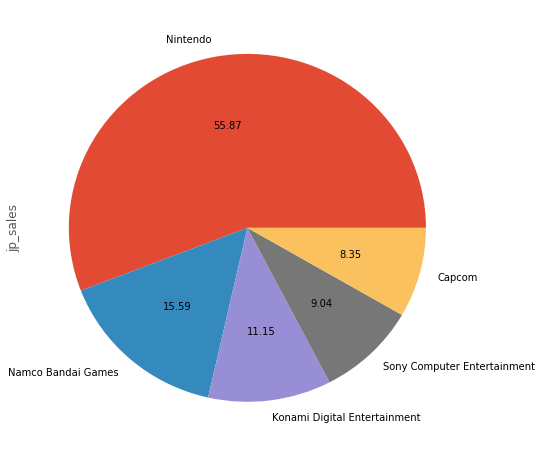

In [52]:
games.groupby("publisher")["jp_sales"].sum().sort_values(ascending=False).head().plot(kind="pie", 
                                                                                      figsize = (8,8), 
                                                                                      autopct='%.2f' 
                                                                                     )

In [53]:
#games.groupby("publisher")["other_sales"].sum().sort_values(ascending=False).head().plot(kind="pie", 
#                                                                                      figsize = (8,8), 
#                                                                                      autopct='%.2f' 
#                                                                                     )

### 7. Is there a relationship between critic/user score and sales?

In [54]:
games.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count
year_of_release,1.000000,-0.093133,0.004663,-0.165577,0.038227,-0.075867,0.010882,0.223997,-0.265660,0.175161
na_sales,-0.093133,1.000000,0.765340,0.449666,0.638693,0.941014,0.240821,0.295406,0.086150,0.246426
eu_sales,0.004663,0.765340,1.000000,0.435077,0.722795,0.901236,0.220805,0.277527,0.055295,0.283357
jp_sales,-0.165577,0.449666,0.435077,1.000000,0.291088,0.612339,0.152629,0.180214,0.125577,0.075635
other_sales,0.038227,0.638693,0.722795,0.291088,1.000000,0.749257,0.198603,0.251633,0.057080,0.238979
global_sales,-0.075867,0.941014,0.901236,0.612339,0.749257,1.000000,0.245534,0.303564,0.088091,0.265009
critic_score,0.010882,0.240821,0.220805,0.152629,0.198603,0.245534,1.000000,0.425560,0.581122,0.264409
critic_count,0.223997,0.295406,0.277527,0.180214,0.251633,0.303564,0.425560,1.000000,0.194095,0.362331
user_score,-0.265660,0.086150,0.055295,0.125577,0.057080,0.088091,0.581122,0.194095,1.000000,0.027030
user_count,0.175161,0.246426,0.283357,0.075635,0.238979,0.265009,0.264409,0.362331,0.027030,1.000000


### 8. Is there a relationship between game rating and sales?

In [56]:
#global sales by rating
games.groupby("rating")["global_sales"].mean().sort_values(ascending=False)

rating
AO         1.950000
K-A        1.443333
M          0.942956
E          0.610830
T          0.504694
E10+       0.461838
Unknown    0.421161
EC         0.222500
RP         0.026667
Name: global_sales, dtype: float64

# Modeling

In [57]:
#model based on games with non-null values

games2 = games.dropna(axis=0)

In [58]:
games2.isnull().sum()

platform           0
year_of_release    0
genre              0
publisher          0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
global_sales       0
critic_score       0
critic_count       0
user_score         0
user_count         0
developer          0
rating             0
dtype: int64

In [59]:
games2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7016 entries, Wii Sports - Wii - 2006 to 15 Days - PC - 2009
Data columns (total 15 columns):
platform           7016 non-null object
year_of_release    7016 non-null int64
genre              7016 non-null object
publisher          7016 non-null object
na_sales           7016 non-null float64
eu_sales           7016 non-null float64
jp_sales           7016 non-null float64
other_sales        7016 non-null float64
global_sales       7016 non-null float64
critic_score       7016 non-null float64
critic_count       7016 non-null float64
user_score         7016 non-null float64
user_count         7016 non-null float64
developer          7016 non-null object
rating             7016 non-null object
dtypes: float64(9), int64(1), object(5)
memory usage: 877.0+ KB


In [60]:
games2 = pd.get_dummies(games2, columns=["platform", "genre", "rating"], drop_first=True)

In [61]:
games2.columns

Index(['year_of_release', 'publisher', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'global_sales', 'critic_score', 'critic_count',
       'user_score', 'user_count', 'developer', 'platform_DC', 'platform_DS',
       'platform_GBA', 'platform_GC', 'platform_PC', 'platform_PS',
       'platform_PS2', 'platform_PS3', 'platform_PS4', 'platform_PSP',
       'platform_PSV', 'platform_Wii', 'platform_WiiU', 'platform_X360',
       'platform_XB', 'platform_XOne', 'genre_Adventure', 'genre_Fighting',
       'genre_Misc', 'genre_Platform', 'genre_Puzzle', 'genre_Racing',
       'genre_Role-Playing', 'genre_Shooter', 'genre_Simulation',
       'genre_Sports', 'genre_Strategy', 'rating_E', 'rating_E10+',
       'rating_K-A', 'rating_M', 'rating_RP', 'rating_T', 'rating_Unknown'],
      dtype='object')

In [62]:
games2.columns = games2.columns.str.lower()

### Model 1: RandomForestRegressor - no NaN values

In [63]:
#select non-object features, select target
features = games2.drop(['na_sales', 'eu_sales', 'jp_sales','other_sales', 'global_sales', 'publisher', 'developer'], axis = 1)

X = features
y = games2.global_sales

In [64]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

In [65]:
#initialize model
rfreg = RandomForestRegressor()

In [66]:
#find best estimator

estimator_range = range(10,100,10)

RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [67]:
# best estimator
#sorted(zip(RMSE_scores, estimator_range))[0]

##(1.3665936124109401, 30)

In [68]:
#find max features

feature_range = range(1, len(X.columns) + 1)

RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=30, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [165]:
# show the best RMSE and the corresponding max_features
#sorted(zip(RMSE_scores, feature_range))[0]

##(1.3168854844578177, 8)

###(1.326479076225888, 1)

In [70]:
#fit with best params
rfreg = RandomForestRegressor(n_estimators=30, 
                              max_features=1,
                              oob_score=True)

In [71]:
rfreg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [72]:
feat_importance = pd.DataFrame(
    {'feature':X.columns, 'importance':rfreg.feature_importances_}
).sort_values('importance', ascending = False)

In [73]:
feat_importance.head(5)

,feature,importance
4,user_count,0.235734
1,critic_score,0.166820
2,critic_count,0.151780
3,user_score,0.107763
0,year_of_release,0.080674


In [74]:
rfreg.oob_score_

0.33355493099509503

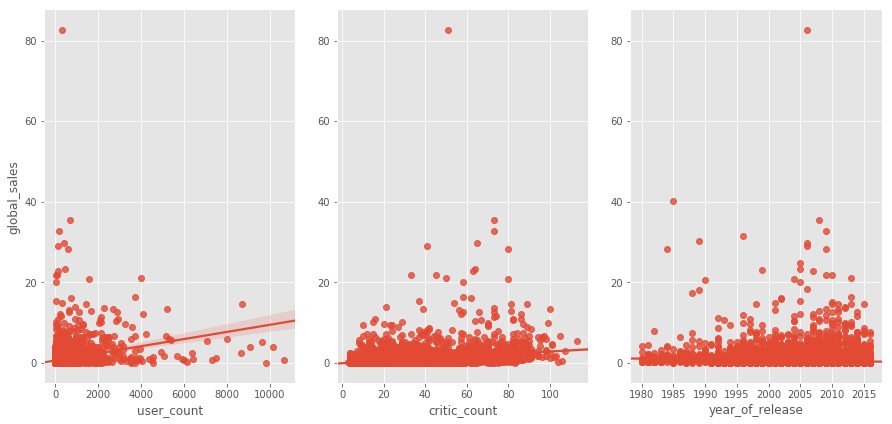

In [75]:
sns.pairplot(games, x_vars = ["user_count", "critic_count", "year_of_release"], y_vars="global_sales",
             size = 6, aspect = .7, kind = "reg");

In [76]:
games2.corr().sort_values(by = "global_sales", ascending=False)

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,...,genre_simulation,genre_sports,genre_strategy,rating_e,rating_e10+,rating_k-a,rating_m,rating_rp,rating_t,rating_unknown
global_sales,0.003151,0.955486,0.938666,0.612535,0.804510,1.000000,0.237021,0.289287,0.088528,0.262931,...,-0.010675,0.022698,-0.054622,0.056914,-0.037028,0.007094,0.057510,-0.006372,-0.071093,-0.031066
na_sales,-0.019835,1.000000,0.839996,0.467128,0.727136,0.955486,0.233437,0.282965,0.086438,0.244487,...,-0.019229,0.039047,-0.057798,0.056746,-0.032909,-0.001614,0.059497,-0.006870,-0.074209,-0.036959
eu_sales,0.038479,0.839996,1.000000,0.518729,0.716478,0.938666,0.212080,0.264292,0.055524,0.282621,...,-0.003377,0.015654,-0.042877,0.046691,-0.036790,-0.001285,0.067689,-0.004926,-0.071641,-0.022780
other_sales,0.039221,0.727136,0.716478,0.394244,1.000000,0.804510,0.191158,0.238431,0.057314,0.239167,...,-0.019974,0.026025,-0.044562,0.024795,-0.025161,-0.002308,0.070898,-0.004848,-0.060982,-0.024840
jp_sales,-0.040503,0.467128,0.518729,1.000000,0.394244,0.612535,0.146213,0.167444,0.127079,0.072423,...,0.018798,-0.038545,-0.034386,0.062771,-0.030474,0.058699,-0.035742,-0.003741,-0.007391,-0.009979
critic_count,0.198133,0.282965,0.264292,0.167444,0.238431,0.289287,0.392799,1.000000,0.194095,0.362331,...,-0.062697,-0.114973,0.004199,-0.205816,-0.081622,-0.008586,0.278527,-0.016990,0.029774,-0.046980
user_count,0.196605,0.244487,0.282621,0.072423,0.239167,0.262931,0.264409,0.362331,0.018818,1.000000,...,-0.030157,-0.088442,0.014035,-0.131183,-0.058827,-0.002574,0.285796,-0.004568,-0.073417,-0.006656
critic_score,-0.011929,0.233437,0.212080,0.146213,0.191158,0.237021,1.000000,0.392799,0.581122,0.264409,...,-0.004168,0.110070,0.037233,0.023266,-0.057775,0.018711,0.063286,-0.011859,-0.033467,-0.009853
user_score,-0.248989,0.086438,0.055524,0.127079,0.057314,0.088528,0.581122,0.194095,1.000000,0.018818,...,0.000777,-0.020972,0.017827,-0.004527,-0.076566,0.001801,-0.003683,-0.022060,0.064323,-0.006455
platform_wii,0.057837,0.093322,0.076526,0.042553,0.043327,0.084983,-0.117466,-0.073235,-0.052510,-0.053869,...,0.015145,0.014279,-0.039411,0.035926,0.118745,-0.003279,-0.099453,-0.004637,-0.030182,-0.021952


In [77]:
#RMSE RandomForestRegressor

rfreg.fit(X_train, y_train)

y_pred = rfreg.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1.3579175432816077

In [78]:
#R2 RandomForestRegressor
y_pred = rfreg.predict(X)

metrics.r2_score(y,y_pred)

0.78586172587078462

### Model 2: Multiple LinearRegression - no NaN values

In [79]:
games2.columns

Index(['year_of_release', 'publisher', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'global_sales', 'critic_score', 'critic_count',
       'user_score', 'user_count', 'developer', 'platform_dc', 'platform_ds',
       'platform_gba', 'platform_gc', 'platform_pc', 'platform_ps',
       'platform_ps2', 'platform_ps3', 'platform_ps4', 'platform_psp',
       'platform_psv', 'platform_wii', 'platform_wiiu', 'platform_x360',
       'platform_xb', 'platform_xone', 'genre_adventure', 'genre_fighting',
       'genre_misc', 'genre_platform', 'genre_puzzle', 'genre_racing',
       'genre_role-playing', 'genre_shooter', 'genre_simulation',
       'genre_sports', 'genre_strategy', 'rating_e', 'rating_e10+',
       'rating_k-a', 'rating_m', 'rating_rp', 'rating_t', 'rating_unknown'],
      dtype='object')

In [80]:
#select top 5 features
cols2 = ["user_count", "critic_score", "critic_count", "year_of_release", "user_score"]

In [81]:
X = games2[cols2]
y = games2.global_sales

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

In [83]:
#RMSE LinearRegression()

lr = LinearRegression()

lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, lr_y_pred))

2.3865443410625167

In [84]:
#R2 LinearRegression
y_pred = lr.predict(X)

metrics.r2_score(y,y_pred)

0.13052648027644842

### Linear vs. Ridge vs. Lasso

In [85]:
#LinearRegression
lr.fit(X,y)
lr.score(X,y)

0.13131505105612018

In [86]:
cross_val_score(LinearRegression(),X,y,cv=5,scoring="r2").mean()

-331.72311842124219

In [87]:
#Ridge
ridge = Ridge(alpha=100)
ridge.fit(X,y)
ridge.score(X,y)

0.13131473917719128

In [88]:
cross_val_score(Ridge(alpha=100),X,y,cv=5,scoring="r2").mean()

-331.53824958184612

In [89]:
#Lasso
lasso = Lasso(alpha=1)
lasso.fit(X,y)
lasso.score(X,y)

0.12307066673537825

In [90]:
cross_val_score(Lasso(alpha=1),X,y,cv=5,scoring="r2").mean()

-310.23420433610198

In [91]:
coef = lasso.coef_
coef

array([ 0.00059931,  0.01237573,  0.01644917, -0.        ,  0.        ])

In [92]:
sorted(dict(zip(X.columns, coef)).items(), key = lambda x:x[1])

[('year_of_release', -0.0),
 ('user_score', 0.0),
 ('user_count', 0.00059931399358742357),
 ('critic_score', 0.012375732295468757),
 ('critic_count', 0.016449173984092218)]

### Polynomial vs. Ridge vs. Lasso

In [93]:
poly = PolynomialFeatures(degree=2)
Xp = poly.fit_transform(X)

In [94]:
lr = LinearRegression()
lr.fit(Xp,y)
lr.score(Xp,y)

0.1760307173930723

In [95]:
cross_val_score(LinearRegression(),Xp,y,cv=10,scoring="r2").mean()

-1126.5959823414244

In [96]:
rid = Ridge(alpha=1500000)
rid.fit(Xp,y)
rid.score(Xp,y)

0.17022296791974767

In [97]:
cross_val_score(Ridge(alpha=1500000),Xp,y,cv=5,scoring="r2").mean()

-292.67410301114876

In [98]:
las = Lasso(alpha=500)
las.fit(Xp,y)
las.score(Xp,y)

0.14999774344811245

In [99]:
cross_val_score(Lasso(alpha=500),X,y,cv=5,scoring="r2").mean()

-436.09773436178102

### Model 3: RandomForestRegressor - drop critic/user columns

In [100]:
#drop columns with Nans
games3 = games.drop(["critic_score", "critic_count", "user_score", "user_count"], axis = 1)

In [101]:
games3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, Wii Sports - Wii - 2006 to Winning Post 8 2016 - PSV - 2016
Data columns (total 11 columns):
platform           16712 non-null object
year_of_release    16712 non-null int64
genre              16712 non-null object
publisher          16712 non-null object
na_sales           16712 non-null float64
eu_sales           16712 non-null float64
jp_sales           16712 non-null float64
other_sales        16712 non-null float64
global_sales       16712 non-null float64
developer          16712 non-null object
rating             16712 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [102]:
#create dummy features
games3 = pd.get_dummies(games3, columns=["platform", "genre", "rating"], drop_first=True)

In [103]:
games3.shape

(16712, 57)

In [104]:
games3.columns = games3.columns.str.lower()

In [105]:
games3.columns

Index(['year_of_release', 'publisher', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'global_sales', 'developer', 'platform_3do',
       'platform_3ds', 'platform_dc', 'platform_ds', 'platform_gb',
       'platform_gba', 'platform_gc', 'platform_gen', 'platform_gg',
       'platform_n64', 'platform_nes', 'platform_ng', 'platform_pc',
       'platform_pcfx', 'platform_ps', 'platform_ps2', 'platform_ps3',
       'platform_ps4', 'platform_psp', 'platform_psv', 'platform_sat',
       'platform_scd', 'platform_snes', 'platform_tg16', 'platform_ws',
       'platform_wii', 'platform_wiiu', 'platform_x360', 'platform_xb',
       'platform_xone', 'genre_adventure', 'genre_fighting', 'genre_misc',
       'genre_platform', 'genre_puzzle', 'genre_racing', 'genre_role-playing',
       'genre_shooter', 'genre_simulation', 'genre_sports', 'genre_strategy',
       'rating_e', 'rating_e10+', 'rating_ec', 'rating_k-a', 'rating_m',
       'rating_rp', 'rating_t', 'rating_unknown'],
      dtyp

In [106]:
#select features & target
features = games3.drop(['na_sales', 'eu_sales', 'jp_sales','other_sales', 'global_sales', 'publisher', 'developer'], axis = 1)

X = features
y = games3.global_sales

In [107]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

In [108]:
#initialize model
rfreg = RandomForestRegressor()

In [109]:
#find best estimator

estimator_range = range(10,100,10)

RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [110]:
# best estimator
#sorted(zip(RMSE_scores, estimator_range))[0]

#(1.4249166693470103, 10)

##(1.4191678224895701, 50)

(1.3938191441943293, 20)

In [111]:
#find max features

feature_range = range(1, len(X.columns) + 1)

RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=50, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [112]:
# show the best RMSE and the corresponding max_features
#sorted(zip(RMSE_scores, feature_range))[0]

#(1.3716112809883985, 5)

##(1.3823456715803988, 9)

(1.3823456715803988, 9)

In [113]:
#fit with best params
rfreg = RandomForestRegressor(n_estimators=50, 
                              max_features=9,
                              oob_score=True)

In [114]:
rfreg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [115]:
feat_importance = pd.DataFrame(
    {'feature':X.columns, 'importance':rfreg.feature_importances_}
).sort_values('importance', ascending = False)

In [116]:
feat_importance.head(9)

,feature,importance
0,year_of_release,0.531569
40,genre_sports,0.079469
34,genre_platform,0.029911
38,genre_shooter,0.026154
5,platform_gb,0.025620
36,genre_racing,0.024429
37,genre_role-playing,0.021929
26,platform_wii,0.021310
42,rating_e,0.020704


In [117]:
rfreg.oob_score_

-0.16305258127046174

In [118]:
#RMSE RandomForestRegressor

rfreg.fit(X_train, y_train)

y_pred = rfreg.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1.9842361795161505

In [119]:
#R2 RandomForestRegressor
y_pred = rfreg.predict(X)

metrics.r2_score(y,y_pred)

0.18011692525218037

### Model 4: Multiple Linear Regression - drop critic/user columns

In [120]:
games3.columns

Index(['year_of_release', 'publisher', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'global_sales', 'developer', 'platform_3do',
       'platform_3ds', 'platform_dc', 'platform_ds', 'platform_gb',
       'platform_gba', 'platform_gc', 'platform_gen', 'platform_gg',
       'platform_n64', 'platform_nes', 'platform_ng', 'platform_pc',
       'platform_pcfx', 'platform_ps', 'platform_ps2', 'platform_ps3',
       'platform_ps4', 'platform_psp', 'platform_psv', 'platform_sat',
       'platform_scd', 'platform_snes', 'platform_tg16', 'platform_ws',
       'platform_wii', 'platform_wiiu', 'platform_x360', 'platform_xb',
       'platform_xone', 'genre_adventure', 'genre_fighting', 'genre_misc',
       'genre_platform', 'genre_puzzle', 'genre_racing', 'genre_role-playing',
       'genre_shooter', 'genre_simulation', 'genre_sports', 'genre_strategy',
       'rating_e', 'rating_e10+', 'rating_ec', 'rating_k-a', 'rating_m',
       'rating_rp', 'rating_t', 'rating_unknown'],
      dtyp

In [121]:
#select features & target
cols3 = ['year_of_release', 'genre_sports', 'rating_e','genre_platform', 'platform_gb', 'genre_shooter', 'genre_racing','genre_role-playing','genre_misc']

X = games3[cols3]
y = games3.global_sales

In [122]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

In [123]:
#RMSE LinearRegression()

lr = LinearRegression()

lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, lr_y_pred))

1.8279840065026267

In [124]:
#R2 LinearRegression
y_pred = lr.predict(X)

metrics.r2_score(y,y_pred)

0.022059457481356071

In [125]:
#LinearRegression
lr.fit(X,y)
lr.score(X,y)

0.022662012775348295

In [126]:
cross_val_score(LinearRegression(),X,y,cv=5,scoring="r2").mean()

-763.77367046721827

In [127]:
#Lasso
lasso = Lasso(alpha=1)
lasso.fit(X,y)
lasso.score(X,y)

0.0

In [128]:
coef = lasso.coef_
coef

array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])

In [129]:
#Polynomial regressions
poly = PolynomialFeatures(degree=2)
Xp = poly.fit_transform(X)

In [130]:
lr = LinearRegression()
lr.fit(Xp,y)
lr.score(Xp,y)

0.03648038603787751

In [131]:
cross_val_score(LinearRegression(),Xp,y,cv=10,scoring="r2").mean()

-2421.8822981502954

In [132]:
las = Lasso(alpha=500)
las.fit(Xp,y)
las.score(Xp,y)

0.0055501964364326195

In [133]:
cross_val_score(Lasso(alpha=500),X,y,cv=5,scoring="r2").mean()

-853.52482810392507

### Model with filled NaN values

In [134]:
#games["critic_score"].sort_values(ascending=False).head()

In [135]:
#games["user_score"].sort_values(ascending=False).head()

In [136]:
games4 = games.copy()

In [137]:
games4.groupby("genre")["critic_score"].mean()

genre
Action          66.629101
Adventure       65.331269
Fighting        69.217604
Misc            66.619503
Platform        68.058350
Puzzle          67.424107
Racing          67.963612
Role-Playing    72.652646
Shooter         70.181144
Simulation      68.619318
Sports          71.958927
Strategy        72.086093
Name: critic_score, dtype: float64

In [138]:
games4.groupby("genre")["critic_count"].mean()

genre
Action          27.780952
Adventure       22.114551
Fighting        27.909535
Misc            21.533461
Platform        23.698189
Puzzle          20.308036
Racing          23.028302
Role-Playing    32.489824
Shooter         35.610169
Simulation      21.446023
Sports          21.029338
Strategy        28.271523
Name: critic_count, dtype: float64

In [139]:
games4.groupby("genre")["user_score"].mean()

genre
Action          7.054044
Adventure       7.133000
Fighting        7.302506
Misc            6.819362
Platform        7.301402
Puzzle          7.175000
Racing          7.036193
Role-Playing    7.619515
Shooter         7.041883
Simulation      7.134593
Sports          6.962523
Strategy        7.295177
Name: user_score, dtype: float64

In [140]:
games4.groupby("genre")["user_count"].mean()

genre
Action          188.889617
Adventure       103.410000
Fighting         64.929825
Misc             31.113895
Platform        109.128505
Puzzle           32.500000
Racing           69.372855
Role-Playing    320.746972
Shooter         374.577922
Simulation       82.656977
Sports           41.513612
Strategy        196.221865
Name: user_count, dtype: float64

In [141]:
#fill nan scores with mean value grouped by genre
#fill nan counts with mean value grouped by genre
c_count = dict(games4.groupby("genre")["critic_count"].mean())
c_score = dict(games4.groupby("genre")["critic_score"].mean())
u_count = dict(games4.groupby("genre")["user_count"].mean())
u_score = dict(games4.groupby("genre")["user_score"].mean())

In [142]:
def imputer_cc(i):
    if pd.isnull(i.critic_count):
        return c_count[i.genre]
    else:
        return i.critic_count
    
def imputer_cs(i):
    if pd.isnull(i.critic_score):
        return c_score[i.genre]
    else:
        return i.critic_score
    
def imputer_uc(i):
    if pd.isnull(i.user_count):
        return u_count[i.genre]
    else:
        return i.user_count
    
def imputer_us(i):
    if pd.isnull(i.user_score):
        return u_score[i.genre]
    else:
        return i.user_score

In [143]:
games4["critic_count"] = games4.apply(imputer_cc, axis = 1)
games4["critic_score"] = games4.apply(imputer_cs, axis = 1)
games4["user_count"] = games4.apply(imputer_uc, axis = 1)
games4["user_score"] = games4.apply(imputer_us, axis = 1)

In [144]:
games4.isnull().sum()

platform           0
year_of_release    0
genre              0
publisher          0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
global_sales       0
critic_score       0
critic_count       0
user_score         0
user_count         0
developer          0
rating             0
dtype: int64

In [145]:
#games4.loc[games4["concatenated"] == "Pokemon Red/Pokemon Blue - GB - 1996"]

### Model 5: RandomForestRegressor - mean critic & user scores/counts

In [146]:
games4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, Wii Sports - Wii - 2006 to Winning Post 8 2016 - PSV - 2016
Data columns (total 15 columns):
platform           16712 non-null object
year_of_release    16712 non-null int64
genre              16712 non-null object
publisher          16712 non-null object
na_sales           16712 non-null float64
eu_sales           16712 non-null float64
jp_sales           16712 non-null float64
other_sales        16712 non-null float64
global_sales       16712 non-null float64
critic_score       16712 non-null float64
critic_count       16712 non-null float64
user_score         16712 non-null float64
user_count         16712 non-null float64
developer          16712 non-null object
rating             16712 non-null object
dtypes: float64(9), int64(1), object(5)
memory usage: 2.0+ MB


In [147]:
#create dummy features
games4 = pd.get_dummies(games4, columns=["platform", "genre", "rating"], drop_first=True)

games4.columns = games4.columns.str.lower()

In [148]:
#select features & target
features = games4.drop(['na_sales', 'eu_sales', 'jp_sales','other_sales', 'global_sales', 'publisher', 'developer'], axis = 1)

X = features
y = games4.global_sales

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

In [149]:
#initialize model
rfreg = RandomForestRegressor()

In [150]:
#find best estimator

estimator_range = range(10,100,10)

RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [151]:
# best estimator
#sorted(zip(RMSE_scores, estimator_range))[0]

#(1.1714301142064518, 80)
#(1.1714512313684999, 60)

(1.1649618447919687, 50)

In [152]:
#find max features

feature_range = range(1, len(X.columns) + 1)

RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=60, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [153]:
# show the best RMSE and the corresponding max_features
#sorted(zip(RMSE_scores, feature_range))[0]

#(1.1563254645809358, 9)
#(1.1542467191468502, 9)

(1.1542467191468502, 9)

In [154]:
#fit with best params
rfreg = RandomForestRegressor(n_estimators=60, 
                              max_features=9,
                              oob_score=True)

rfreg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [155]:
feat_importance = pd.DataFrame(
    {'feature':X.columns, 'importance':rfreg.feature_importances_}
).sort_values('importance', ascending = False)


feat_importance.head(9)

,feature,importance
0,year_of_release,0.188526
4,user_count,0.177952
2,critic_count,0.129363
1,critic_score,0.128208
3,user_score,0.069284
30,platform_wii,0.055148
44,genre_sports,0.030492
46,rating_e,0.024625
9,platform_gb,0.018986


In [156]:
np.array(feat_importance.head(9))

array([['year_of_release', 0.1885263417225949],
       ['user_count', 0.17795197747230077],
       ['critic_count', 0.1293632363328367],
       ['critic_score', 0.12820834323961924],
       ['user_score', 0.06928439756371092],
       ['platform_wii', 0.055147585815711476],
       ['genre_sports', 0.030492200236276874],
       ['rating_e', 0.024625236762678603],
       ['platform_gb', 0.018985995348182093]], dtype=object)

In [157]:
rfreg.oob_score_

#0.19922549413988777
#0.2187315710379889

0.21381375785827761

In [158]:
#RMSE RandomForestRegressor

rfreg.fit(X_train, y_train)

y_pred = rfreg.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1.2361490862135409

In [159]:
#R2 RandomForestRegressor
y_pred = rfreg.predict(X)

metrics.r2_score(y,y_pred)

0.65535578529920735

### Linear Regression

In [161]:
cols4 = ['user_count', 'year_of_release', 'critic_score','genre_platform', 'platform_wii', 'genre_sports', 'rating_e']

X = games4[cols4]
y = games4.global_sales

In [162]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

#RMSE LinearRegression()

lr = LinearRegression()

lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, lr_y_pred))

1.0368171285980348

In [163]:
#R2 LinearRegression
y_pred = lr.predict(X)

metrics.r2_score(y,y_pred)

0.090698236917735819

In [164]:
rfreg.oob_score_

0.16565321600738192

# Next Steps

- train/test models for specific sales resions: NA, EU, JP
- re-group games by platform, publisher
- investigate impact of mobile gaming